In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os 
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

## Подготовка данных

In [2]:
def load_data(data_path = None): #функция для считывания .csv - файла
    csv_path = os.path.join(data_path)
    return pd.read_csv(csv_path)

In [3]:
gender_submission = load_data("gender_submission.csv")
train_set = load_data("train.csv")
test_set = load_data("test.csv")

In [4]:
mean_age = train_set["Age"].mean()
mean_age_test = test_set["Age"].mean()
train_set["Age"].fillna(mean_age, inplace = True)
test_set["Age"].fillna(mean_age_test, inplace = True)

In [5]:
Embarked_cat = train_set['Embarked']
Embarked_cat_encoded, Embarked_cat_categories = Embarked_cat.factorize(na_sentinel = 0)
encoder = OneHotEncoder(sparse=False)
Embarked_cat_1hot = encoder.fit_transform(Embarked_cat_encoded.reshape(-1, 1))
train_set['Embarked'] = Embarked_cat_encoded
train_set['Embarked_cat_A'] = Embarked_cat_1hot[:,0]
train_set['Embarked_cat_B'] = Embarked_cat_1hot[:,1]
train_set['Embarked_cat_C'] = Embarked_cat_1hot[:,2]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
Embarked_cat_test = test_set['Embarked']
Embarked_cat_test_encoded, Embarked_cat_test_categories = Embarked_cat_test.factorize()
Embarked_cat_test_1hot = encoder.fit_transform(Embarked_cat_test_encoded.reshape(-1, 1))
test_set['Embarked'] = Embarked_cat_test_encoded
test_set['Embarked_cat_A'] = Embarked_cat_test_1hot[:,0]
test_set['Embarked_cat_B'] = Embarked_cat_test_1hot[:,1]
test_set['Embarked_cat_C'] = Embarked_cat_test_1hot[:,2]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
Sex_cat = train_set['Sex']
Sex_cat_encoded, Sex_cat_categories = Sex_cat.factorize()
Sex_cat_1hot = encoder.fit_transform(Sex_cat_encoded.reshape(-1, 1))
train_set['Sex'] = Sex_cat_encoded
train_set['Sex_cat_A'] = Sex_cat_1hot[:,0]
train_set['Sex_cat_B'] = Sex_cat_1hot[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
Sex_cat_test = test_set['Sex']
Sex_cat_test_encoded, Sex_cat_test_categories = Sex_cat_test.factorize()
Sex_cat_test_1hot = encoder.fit_transform(Sex_cat_test_encoded.reshape(-1, 1))
test_set['Sex'] = Sex_cat_test_encoded
test_set['Sex_cat_A'] = Sex_cat_test_1hot[:,0]
test_set['Sex_cat_B'] = Sex_cat_test_1hot[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [27]:
corr_matrix = train_set.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived          1.000000
Sex_cat_B         0.543351
Sex               0.543351
Fare              0.257307
Embarked_cat_B    0.168240
Embarked          0.106811
Parch             0.081629
Embarked_cat_C    0.003650
PassengerId      -0.005007
SibSp            -0.035322
Age              -0.069809
Embarked_cat_A   -0.149683
Pclass           -0.338481
Sex_cat_A        -0.543351
Name: Survived, dtype: float64

In [9]:
def categorized_age (dataframe,column_to_attr, column):
    dataframe[column] = np.ceil(train_set[column_to_attr])
    a = dataframe[column].copy()
    for item in dataframe[column].index:
        x = dataframe[column][item]
        if x < 18:
            x = 1
        elif x >= 18 and x < 28:
            x = 2
        elif x >= 28 and x < 30:
            x = 3
        elif x >= 30 and x < 40:
            x = 4
        elif x >= 40 and x < 46:
            x = 5
        elif x >= 46:
            x = 6
        a.iloc[item] = x
    dataframe[column] = a 
    return dataframe[column]      

In [40]:
def categorized_Fare (dataframe,column_to_attr, column):
    dataframe[column] = np.ceil(train_set[column_to_attr])
    a = dataframe[column].copy()
    for item in dataframe[column].index:
        x = dataframe[column][item]
        if x < 8:
            x = 1
        elif x >= 8 and x < 15:
            x = 2
        elif x >= 15 and x < 23:
            x = 3
        elif x >= 23 and x < 32:
            x = 4
        elif x >= 32 :
            x = 5
       
        a.iloc[item] = x
    dataframe[column] = a 
    return dataframe[column]   

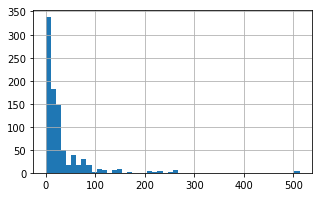

In [38]:
train_set['Fare'].hist(bins=50, figsize=(5,3))
plt.show()

In [39]:
train_set['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [41]:
train_set['Fare_cat'] = categorized_Fare(train_set, column_to_attr='Fare', column = 'Fare_cat')
test_set['Fare_cat'] = categorized_Fare(test_set, column_to_attr='Fare', column='Fare_cat')

Fare_category = train_set['Fare_cat']
Fare_category_encoded, Fare_category_categories = Fare_category.factorize()
Fare_category_1hot = encoder.fit_transform(Fare_category_encoded.reshape(-1, 1))
train_set['Fare_cat'] = Fare_category_encoded
train_set['Fare_category_1'] = Fare_category_1hot[:,0]
train_set['Fare_category_2'] = Fare_category_1hot[:,1]
train_set['Fare_category_3'] = Fare_category_1hot[:,2]
train_set['Fare_category_4'] = Fare_category_1hot[:,3]
train_set['Fare_category_5'] = Fare_category_1hot[:,4]



Fare_category_test = test_set['Fare_cat']
Fare_category_test_encoded, Fare_category_test_categories = Fare_category_test.factorize()
Fare_category_test_1hot = encoder.fit_transform(Fare_category_test_encoded.reshape(-1, 1))
test_set['Fare_cat'] = Fare_category_test_encoded
test_set['Fare_category_1'] = Fare_category_test_1hot[:,0]
test_set['Fare_category_2'] = Fare_category_test_1hot[:,1]
test_set['Fare_category_3'] = Fare_category_test_1hot[:,2]
test_set['Fare_category_4'] = Fare_category_test_1hot[:,3]
test_set['Fare_category_5'] = Fare_category_test_1hot[:,4]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

In [42]:
train_set['age_cat'] = categorized_age(train_set, column_to_attr='Age', column = 'age_cat')
test_set['age_cat'] = categorized_age(test_set, column_to_attr='Age', column='age_cat')

Age_category = train_set['age_cat']
Age_category_encoded, Age_category_categories = Age_category.factorize()
Age_category_1hot = encoder.fit_transform(Age_category_encoded.reshape(-1, 1))
train_set['age_cat'] = Age_category_encoded
train_set['Age_category_1'] = Age_category_1hot[:,0]
train_set['Age_category_2'] = Age_category_1hot[:,1]
train_set['Age_category_3'] = Age_category_1hot[:,2]
train_set['Age_category_4'] = Age_category_1hot[:,3]
train_set['Age_category_5'] = Age_category_1hot[:,4]
train_set['Age_category_6'] = Age_category_1hot[:,5]


Age_category_test = test_set['age_cat']
Age_category_test_encoded, Age_category_test_categories = Age_category_test.factorize()
Age_category_test_1hot = encoder.fit_transform(Age_category_test_encoded.reshape(-1, 1))
test_set['age_cat'] = Age_category_test_encoded
test_set['Age_category_1'] = Age_category_test_1hot[:,0]
test_set['Age_category_2'] = Age_category_test_1hot[:,1]
test_set['Age_category_3'] = Age_category_test_1hot[:,2]
test_set['Age_category_4'] = Age_category_test_1hot[:,3]
test_set['Age_category_5'] = Age_category_test_1hot[:,4]
test_set['Age_category_6'] = Age_category_test_1hot[:,5]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

In [43]:
train_set.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_category_6,Fare_category_1,Fare_category_2,Fare_category_3,Fare_category_4,Fare_category_5,Fare_category_6,Fare_category_7,Fare_category_8,Fare_category_9
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
corr_matrix = train_set.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived           1.000000
Sex                0.543351
Sex_cat_B          0.543351
Fare               0.257307
Fare_category_2    0.233638
Fare_category_9    0.182033
Embarked_cat_B     0.168240
Age_category_4     0.122239
Embarked           0.106811
Fare_cat           0.090540
Parch              0.081629
Fare_category_4    0.081127
age_cat            0.048169
Fare_category_7    0.036956
Embarked_cat_C     0.003650
Fare_category_3    0.002831
Age_category_6    -0.000279
PassengerId       -0.005007
Fare_category_6   -0.007451
Age_category_3    -0.011082
Age_category_5    -0.031390
Age_category_1    -0.031811
Age_category_2    -0.033374
SibSp             -0.035322
Fare_category_8   -0.041166
Age               -0.069809
Fare_category_5   -0.115712
Embarked_cat_A    -0.149683
Fare_category_1   -0.222251
Pclass            -0.338481
Sex_cat_A         -0.543351
Name: Survived, dtype: float64

# Разделяю метки от данных

In [45]:
attr_pr = ['Cabin', 'Name', 'Ticket', 'PassengerId']
train_set_prepared = train_set.drop(attr_pr, axis=1)
corr_matrix = train_set_prepared.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived           1.000000
Sex                0.543351
Sex_cat_B          0.543351
Fare               0.257307
Fare_category_2    0.233638
Fare_category_9    0.182033
Embarked_cat_B     0.168240
Age_category_4     0.122239
Embarked           0.106811
Fare_cat           0.090540
Parch              0.081629
Fare_category_4    0.081127
age_cat            0.048169
Fare_category_7    0.036956
Embarked_cat_C     0.003650
Fare_category_3    0.002831
Age_category_6    -0.000279
Fare_category_6   -0.007451
Age_category_3    -0.011082
Age_category_5    -0.031390
Age_category_1    -0.031811
Age_category_2    -0.033374
SibSp             -0.035322
Fare_category_8   -0.041166
Age               -0.069809
Fare_category_5   -0.115712
Embarked_cat_A    -0.149683
Fare_category_1   -0.222251
Pclass            -0.338481
Sex_cat_A         -0.543351
Name: Survived, dtype: float64

In [46]:
attr = ['Survived','Cabin','PassengerId', 'Name', 'Ticket']
y_train = train_set["Survived"].copy()
passenger_id = train_set['PassengerId'].copy()
x_train = train_set.drop(attr,axis = 1)

In [47]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

## Выбор моделей 

Градиентный спуск

In [48]:
sgd_clf = SGDClassifier()
parametr_sgd = {'loss':['hinge', 'log', 'modified_huber','squared_hinge']
                }
random_search_sgd = RandomizedSearchCV(sgd_clf, param_distributions=parametr_sgd, n_iter=4, 
                                             scoring = 'accuracy', n_jobs=-1, cv=3, random_state=42)
random_search_sgd.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=4, n_jobs=-1,
          param_distributions={'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

Ближайшие соседи

In [49]:
knn_clf = KNeighborsClassifier()
parametr_knn = {'n_neighbors':[1,2,3,7,11,15,50],
                'weights': ['uniform', 'distance'],
                'p': [1, 2] ,
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']  
                }
random_search_neighbors = RandomizedSearchCV(knn_clf, param_distributions=parametr_knn, n_iter=30, 
                                             scoring = 'accuracy', n_jobs=-1, cv=3, random_state=42)
random_search_neighbors.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'n_neighbors': [1, 2, 3, 7, 11, 15, 50], 'weights': ['uniform', 'distance'], 'p': [1, 2], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

Опорные вектора

In [50]:
vector_clf = SVC()
parametr_vector = {'C':[0.5,1,5, 10, 15, 20, 30],
                   'kernel':['rbf', 'linear','sigmoid'],
                   'gamma': [0.1,0.3, 0.5, 1,3,5,10]
                   } 
random_search_vector  = RandomizedSearchCV(vector_clf, param_distributions=parametr_vector, n_iter = 100, 
                                           scoring='accuracy', n_jobs=-1, cv=3, random_state=42)
random_search_vector.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'C': [0.5, 1, 5, 10, 15, 20, 30], 'kernel': ['rbf', 'linear', 'sigmoid'], 'gamma': [0.1, 0.3, 0.5, 1, 3, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [51]:
random_search_vector.best_params_

{'kernel': 'rbf', 'gamma': 0.1, 'C': 20}

Случайный лес

In [52]:
forest_clf = RandomForestClassifier()
param_forest = {'n_estimators':[2,3,5,11,20],
                'bootstrap': [True, False],
                'criterion': ['gini', 'entropy']
                }
random_search_forest  = RandomizedSearchCV(forest_clf, param_distributions=param_forest, n_iter=20,
                                          scoring='accuracy', n_jobs=-1, random_state=42)
random_search_forest.fit(x_train_scaled, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [2, 3, 5, 11, 20], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [53]:
print("Значение правильности для классификатора: ", "Градиентный спуск =  %.5f" % (random_search_sgd.best_score_))
print("Значение правильности для классификатора: ", "Случайный лес =  %.5f" % (random_search_forest.best_score_))
print("Значение правильности для классификатора: ", "Ближайшие соседи =  %.5f" % (random_search_neighbors.best_score_))
print("Значение правильности для классификатора: ", "Опорные вектора = %.5f" % (random_search_vector.best_score_))

Значение правильности для классификатора:  Градиентный спуск =  0.71829
Значение правильности для классификатора:  Случайный лес =  0.81145
Значение правильности для классификатора:  Ближайшие соседи =  0.78227
Значение правильности для классификатора:  Опорные вектора = 0.79686


Высчитываем метрики

In [54]:
def estimate_metrics (clf, X, y, cv = 3, n_jobs = -1):
    y_pred = cross_val_predict(clf, X, y, cv = 3, n_jobs= -1)
    conf_matrix = confusion_matrix(y, y_pred)
    precision_clf = precision_score(y, y_pred)
    recall_clf = recall_score(y, y_pred)
    f1_clf = f1_score(y, y_pred)
    print ("Матрица неточностей: ", conf_matrix)
    print ("Точность: %.5f" %precision_clf)
    print ("Полнота: %.5f" %recall_clf)
    print ("Чувствительность: %.5f" %f1_clf)

In [55]:
metrics_sgd = estimate_metrics(sgd_clf, x_train_scaled, y_train)

Матрица неточностей:  [[416 133]
 [126 216]]
Точность: 0.61891
Полнота: 0.63158
Чувствительность: 0.62518


In [56]:
metrics_forest = estimate_metrics(forest_clf, x_train_scaled, y_train)

Матрица неточностей:  [[487  62]
 [107 235]]
Точность: 0.79125
Полнота: 0.68713
Чувствительность: 0.73552


In [57]:
metrics_vector = estimate_metrics(vector_clf, x_train_scaled, y_train)

Матрица неточностей:  [[482  67]
 [108 234]]
Точность: 0.77741
Полнота: 0.68421
Чувствительность: 0.72784


In [58]:
metrics_neighbors = estimate_metrics(knn_clf, x_train_scaled, y_train)

Матрица неточностей:  [[464  85]
 [128 214]]
Точность: 0.71572
Полнота: 0.62573
Чувствительность: 0.66771


# Прогноз на тестовом наборе

In [59]:
mean_Fare_test = test_set["Fare"].mean()
test_set["Fare"].fillna(mean_Fare_test, inplace = True)

In [60]:
attr_test = ['Cabin', 'Name', 'Ticket', 'PassengerId']
passenger_id = test_set['PassengerId'].copy()
x_test = test_set.drop(attr_test, axis=1)
x_test_scalled = scaler.fit_transform(x_test.astype(np.float64))

In [61]:
test_result = random_search_vector.predict(x_test_scalled)

In [62]:
test_result_knn = random_search_neighbors.predict(x_test_scalled)

In [63]:
test_result_rf = random_search_forest.predict(x_test_scalled)

# Собираю итоговый файл

In [64]:
titanic_result = pd.DataFrame(data = passenger_id)

In [65]:
titanic_result ['Survived'] = test_result

In [66]:
titanic_result_knn = pd.DataFrame(data = passenger_id)
titanic_result_knn['Survived'] = test_result_knn

In [67]:
titanic_result_rf = pd.DataFrame(data = passenger_id)
titanic_result_rf['Survived'] = test_result_rf

In [68]:
titanic_result.to_csv('titanic_result_svc.csv', columns=['PassengerId', 'Survived'], index=False)
titanic_result_knn.to_csv('titanic_result_knn.csv', columns=['PassengerId', 'Survived'], index=False)
titanic_result_rf.to_csv('titanic_result_rf.csv', columns=['PassengerId', 'Survived'], index=False)